In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
from keras import regularizers

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
neurons = 256                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer= 'adam'             
dropout = 0.40                
batch_size = 60              
epochs = 1000                
window_len = 7               
training_size = 0.6          
merge_date = '2017-05-03'     

In [3]:
def get_market_data(market):
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  market_data.columns = [market_data.columns[0]] + ["BTC" + '_' + i for i in market_data.columns[1:]]
  return market_data


def cut_data(data, from_date=merge_date):
  cut_data = data[data['Date'] >= from_date]
  cut_data = cut_data.sort_values(by='Date')
  return cut_data

def split_data(data, training_size=training_size):
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

def create_inputs(data, window_len=window_len):
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
#     scaler = StandardScaler()
#     scaler = scaler.fit(temp_set)
#     temp_set = scaler.transform(temp_set)
    inputs.append(temp_set)  
  return inputs


def create_outputs(data, window_len=window_len):
  return data['BTC_Close**'][window_len:].values
  #return data[:, 0][window_len:]


def to_array(data):
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  model.add(LSTM(neurons, kernel_regularizer=regularizers.l2(0.01), input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=neurons, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
  model.add(Dropout(dropout))
  model.add(Dense(units=50, kernel_regularizer=regularizers.l2(0.01), activation="linear"))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [4]:
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

def plot_results(history, model):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_train)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(Y_test)
  plt.plot(model.predict(X_test))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [5]:
btc_data = get_market_data("bitcoin")

In [6]:
market_data = cut_data(btc_data)
train_set, test_set = split_data(market_data)

train_set = train_set.diff().dropna()
test_set = test_set.diff().dropna()

train_set = train_set.drop("Date",axis=1).drop("BTC_Market Cap", axis=1)
test_set = test_set.drop("Date", axis=1).drop("BTC_Market Cap", axis=1)

Y_train = create_outputs(train_set)
Y_test = create_outputs(test_set)

sc = StandardScaler()
train_set = sc.fit_transform(train_set)
test_set = sc.transform(test_set)

# train_set[:] += 1
# test_set[:] += 1

train_set

array([[-0.03406471,  0.12659333, -0.01685251, -0.00895303,  0.18235803],
       [-0.00838276, -0.09791879, -0.02409556, -0.06654754, -0.03291051],
       [-0.07489144, -0.19934993, -0.07861743, -0.05578239, -0.27289753],
       ...,
       [ 0.02087639, -0.39564595, -1.44980246, -2.12908802, -1.60376141],
       [-2.14935557, -2.30238365, -3.84279485, -2.6279183 ,  1.58538084],
       [-2.73531626, -2.29965644,  0.32653572, -1.21163458, -1.1603516 ]])

In [7]:
X_train = create_inputs(train_set)
X_test = create_inputs(test_set)

X_train, X_test = to_array(X_train), to_array(X_test)

In [8]:
X_train

array([[[-0.03406471,  0.12659333, -0.01685251, -0.00895303,
          0.18235803],
        [-0.00838276, -0.09791879, -0.02409556, -0.06654754,
         -0.03291051],
        [-0.07489144, -0.19934993, -0.07861743, -0.05578239,
         -0.27289753],
        ...,
        [-0.0719558 ,  0.1485998 , -0.0289309 ,  0.14384636,
          0.12525601],
        [ 0.14096528,  0.11400622,  0.13467449, -0.03904519,
         -0.1509193 ],
        [-0.04244391, -0.21155943, -0.09730211, -0.03950904,
         -0.20185175]],

       [[-0.00838276, -0.09791879, -0.02409556, -0.06654754,
         -0.03291051],
        [-0.07489144, -0.19934993, -0.07861743, -0.05578239,
         -0.27289753],
        [-0.06182689, -0.07945769, -0.06852889, -0.06629628,
          0.27666128],
        ...,
        [ 0.14096528,  0.11400622,  0.13467449, -0.03904519,
         -0.1509193 ],
        [-0.04244391, -0.21155943, -0.09730211, -0.03950904,
         -0.20185175],
        [-0.05951337,  0.06229417, -0.03074166, 

In [9]:
btc_model = build_model(X_train, output_size=1, neurons=neurons)
btc_history = btc_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               268288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total para

Epoch 39/1000
244/244 [==============================] - 0s 321us/step - loss: 221243.1872 - mean_absolute_error: 249.0282 - val_loss: 226290.4054 - val_mean_absolute_error: 339.9985
Epoch 40/1000
244/244 [==============================] - 0s 334us/step - loss: 221464.7484 - mean_absolute_error: 249.4960 - val_loss: 227049.1557 - val_mean_absolute_error: 340.6629
Epoch 41/1000
244/244 [==============================] - 0s 351us/step - loss: 222317.7671 - mean_absolute_error: 250.1015 - val_loss: 225590.2837 - val_mean_absolute_error: 339.9418
Epoch 42/1000
244/244 [==============================] - 0s 364us/step - loss: 217631.0809 - mean_absolute_error: 247.8327 - val_loss: 227785.1166 - val_mean_absolute_error: 340.1303
Epoch 43/1000
244/244 [==============================] - 0s 344us/step - loss: 217728.4625 - mean_absolute_error: 245.8090 - val_loss: 231881.8323 - val_mean_absolute_error: 340.3823
Epoch 44/1000
244/244 [==============================] - 0s 330us/step - loss: 218623

Epoch 84/1000
244/244 [==============================] - 0s 320us/step - loss: 205192.3153 - mean_absolute_error: 238.2629 - val_loss: 249035.2714 - val_mean_absolute_error: 348.3305
Epoch 85/1000
244/244 [==============================] - 0s 329us/step - loss: 202517.0973 - mean_absolute_error: 238.0907 - val_loss: 245213.9490 - val_mean_absolute_error: 346.8523
Epoch 86/1000
244/244 [==============================] - 0s 390us/step - loss: 201349.6102 - mean_absolute_error: 237.8178 - val_loss: 242770.5755 - val_mean_absolute_error: 345.8156
Epoch 87/1000
244/244 [==============================] - 0s 390us/step - loss: 195878.1470 - mean_absolute_error: 232.7999 - val_loss: 244468.5500 - val_mean_absolute_error: 346.2904
Epoch 88/1000
244/244 [==============================] - 0s 386us/step - loss: 196277.0829 - mean_absolute_error: 235.6129 - val_loss: 247643.9337 - val_mean_absolute_error: 347.8815
Epoch 89/1000
244/244 [==============================] - 0s 347us/step - loss: 185544

244/244 [==============================] - 0s 382us/step - loss: 104879.2342 - mean_absolute_error: 199.7032 - val_loss: 301511.0276 - val_mean_absolute_error: 377.4390
Epoch 129/1000
244/244 [==============================] - 0s 459us/step - loss: 104526.5250 - mean_absolute_error: 194.2690 - val_loss: 311242.3190 - val_mean_absolute_error: 380.1967
Epoch 130/1000
244/244 [==============================] - 0s 396us/step - loss: 98346.6318 - mean_absolute_error: 191.5298 - val_loss: 291700.0303 - val_mean_absolute_error: 374.3752
Epoch 131/1000
244/244 [==============================] - 0s 415us/step - loss: 91070.8268 - mean_absolute_error: 187.1249 - val_loss: 277341.7929 - val_mean_absolute_error: 368.9112
Epoch 132/1000
244/244 [==============================] - 0s 401us/step - loss: 93580.0449 - mean_absolute_error: 185.8572 - val_loss: 265715.4633 - val_mean_absolute_error: 361.2297
Epoch 133/1000
244/244 [==============================] - 0s 383us/step - loss: 98986.0785 - mean_

Epoch 173/1000
244/244 [==============================] - 0s 320us/step - loss: 88469.7334 - mean_absolute_error: 192.9071 - val_loss: 316829.9344 - val_mean_absolute_error: 390.6032
Epoch 174/1000
244/244 [==============================] - 0s 354us/step - loss: 82635.1431 - mean_absolute_error: 188.3951 - val_loss: 311219.8707 - val_mean_absolute_error: 385.3581
Epoch 175/1000
244/244 [==============================] - 0s 329us/step - loss: 78678.4798 - mean_absolute_error: 182.2070 - val_loss: 301395.6859 - val_mean_absolute_error: 376.9736
Epoch 176/1000
244/244 [==============================] - 0s 329us/step - loss: 87251.4326 - mean_absolute_error: 190.8416 - val_loss: 308721.2396 - val_mean_absolute_error: 381.4017
Epoch 177/1000
244/244 [==============================] - 0s 331us/step - loss: 82892.4210 - mean_absolute_error: 185.0028 - val_loss: 337404.1586 - val_mean_absolute_error: 395.9780
Epoch 178/1000
244/244 [==============================] - 0s 334us/step - loss: 73961

Epoch 218/1000
244/244 [==============================] - 0s 381us/step - loss: 58533.6143 - mean_absolute_error: 162.2334 - val_loss: 273967.1556 - val_mean_absolute_error: 364.8129
Epoch 219/1000
244/244 [==============================] - 0s 400us/step - loss: 58389.1633 - mean_absolute_error: 160.4222 - val_loss: 282343.0311 - val_mean_absolute_error: 369.0436
Epoch 220/1000
244/244 [==============================] - 0s 367us/step - loss: 52787.9517 - mean_absolute_error: 153.8689 - val_loss: 292379.3056 - val_mean_absolute_error: 372.9911
Epoch 221/1000
244/244 [==============================] - 0s 597us/step - loss: 57165.2964 - mean_absolute_error: 154.5402 - val_loss: 295299.1491 - val_mean_absolute_error: 373.2480
Epoch 222/1000
244/244 [==============================] - 0s 453us/step - loss: 53506.1459 - mean_absolute_error: 154.0949 - val_loss: 294087.4596 - val_mean_absolute_error: 374.3025
Epoch 223/1000
244/244 [==============================] - 0s 469us/step - loss: 65268

Epoch 263/1000
244/244 [==============================] - 0s 438us/step - loss: 52298.3767 - mean_absolute_error: 155.6520 - val_loss: 311519.7564 - val_mean_absolute_error: 384.0460
Epoch 264/1000
244/244 [==============================] - 0s 409us/step - loss: 65020.7588 - mean_absolute_error: 162.7092 - val_loss: 310425.7328 - val_mean_absolute_error: 383.0353
Epoch 265/1000
244/244 [==============================] - 0s 378us/step - loss: 64915.4173 - mean_absolute_error: 170.1030 - val_loss: 298460.9603 - val_mean_absolute_error: 378.7393
Epoch 266/1000
244/244 [==============================] - 0s 359us/step - loss: 74748.0009 - mean_absolute_error: 181.5695 - val_loss: 282028.0904 - val_mean_absolute_error: 372.2451
Epoch 267/1000
244/244 [==============================] - 0s 401us/step - loss: 69654.2307 - mean_absolute_error: 171.1761 - val_loss: 276008.2466 - val_mean_absolute_error: 369.7958
Epoch 268/1000
244/244 [==============================] - 0s 468us/step - loss: 75928

Epoch 308/1000
244/244 [==============================] - 0s 474us/step - loss: 54475.4567 - mean_absolute_error: 155.1911 - val_loss: 326257.1923 - val_mean_absolute_error: 394.8053
Epoch 309/1000
244/244 [==============================] - 0s 469us/step - loss: 48019.6489 - mean_absolute_error: 148.3795 - val_loss: 318156.2226 - val_mean_absolute_error: 390.2829
Epoch 310/1000
244/244 [==============================] - 0s 446us/step - loss: 55130.4923 - mean_absolute_error: 155.7296 - val_loss: 308385.5905 - val_mean_absolute_error: 385.7256
Epoch 311/1000
244/244 [==============================] - 0s 495us/step - loss: 49168.1421 - mean_absolute_error: 149.7413 - val_loss: 297772.9804 - val_mean_absolute_error: 380.0410
Epoch 312/1000
244/244 [==============================] - 0s 490us/step - loss: 51474.1143 - mean_absolute_error: 151.1048 - val_loss: 299524.4616 - val_mean_absolute_error: 381.9911
Epoch 313/1000
244/244 [==============================] - 0s 426us/step - loss: 48391

Epoch 353/1000
244/244 [==============================] - 0s 412us/step - loss: 49476.0701 - mean_absolute_error: 149.2222 - val_loss: 320326.6954 - val_mean_absolute_error: 391.5729
Epoch 354/1000
244/244 [==============================] - 0s 368us/step - loss: 49083.7371 - mean_absolute_error: 147.2579 - val_loss: 318941.9374 - val_mean_absolute_error: 391.8999
Epoch 355/1000
244/244 [==============================] - 0s 370us/step - loss: 46924.2245 - mean_absolute_error: 145.5224 - val_loss: 319667.4243 - val_mean_absolute_error: 392.7784
Epoch 356/1000
244/244 [==============================] - 0s 386us/step - loss: 48610.8066 - mean_absolute_error: 147.6644 - val_loss: 319834.4071 - val_mean_absolute_error: 392.1765
Epoch 357/1000
244/244 [==============================] - 0s 423us/step - loss: 47523.8718 - mean_absolute_error: 146.2439 - val_loss: 326179.2260 - val_mean_absolute_error: 395.1074
Epoch 358/1000
244/244 [==============================] - 0s 400us/step - loss: 52371

Epoch 398/1000
244/244 [==============================] - 0s 411us/step - loss: 51274.1958 - mean_absolute_error: 152.3707 - val_loss: 360131.3616 - val_mean_absolute_error: 414.5220
Epoch 399/1000
244/244 [==============================] - 0s 452us/step - loss: 45091.9255 - mean_absolute_error: 141.9448 - val_loss: 345899.6493 - val_mean_absolute_error: 407.8940
Epoch 400/1000
244/244 [==============================] - 0s 493us/step - loss: 43326.2547 - mean_absolute_error: 138.0193 - val_loss: 338463.1525 - val_mean_absolute_error: 403.2007
Epoch 401/1000
244/244 [==============================] - 0s 454us/step - loss: 47918.2649 - mean_absolute_error: 149.4216 - val_loss: 327273.8046 - val_mean_absolute_error: 396.1834
Epoch 402/1000
244/244 [==============================] - 0s 433us/step - loss: 42857.1356 - mean_absolute_error: 138.4940 - val_loss: 321849.4021 - val_mean_absolute_error: 393.0700
Epoch 403/1000
244/244 [==============================] - 0s 434us/step - loss: 45839

Epoch 443/1000
244/244 [==============================] - 0s 412us/step - loss: 42100.8101 - mean_absolute_error: 136.9124 - val_loss: 366491.7619 - val_mean_absolute_error: 415.8701
Epoch 444/1000
244/244 [==============================] - 0s 429us/step - loss: 47867.4302 - mean_absolute_error: 142.7395 - val_loss: 375541.2551 - val_mean_absolute_error: 419.7144
Epoch 445/1000
244/244 [==============================] - 0s 420us/step - loss: 43727.1413 - mean_absolute_error: 138.3886 - val_loss: 368824.8394 - val_mean_absolute_error: 416.8545
Epoch 446/1000
244/244 [==============================] - 0s 431us/step - loss: 46328.8040 - mean_absolute_error: 141.1470 - val_loss: 365851.2488 - val_mean_absolute_error: 415.5351
Epoch 447/1000
244/244 [==============================] - 0s 415us/step - loss: 44002.4777 - mean_absolute_error: 143.1916 - val_loss: 373529.3644 - val_mean_absolute_error: 419.2152
Epoch 448/1000
244/244 [==============================] - 0s 400us/step - loss: 43293

Epoch 488/1000
244/244 [==============================] - 0s 667us/step - loss: 43608.1565 - mean_absolute_error: 136.5094 - val_loss: 364080.6102 - val_mean_absolute_error: 418.7407
Epoch 489/1000
244/244 [==============================] - 0s 707us/step - loss: 44200.8744 - mean_absolute_error: 137.1727 - val_loss: 375884.9574 - val_mean_absolute_error: 422.4929
Epoch 490/1000
244/244 [==============================] - 0s 695us/step - loss: 41868.6836 - mean_absolute_error: 136.7815 - val_loss: 386611.5414 - val_mean_absolute_error: 428.1543
Epoch 491/1000
244/244 [==============================] - 0s 644us/step - loss: 43940.6394 - mean_absolute_error: 137.5637 - val_loss: 387422.6576 - val_mean_absolute_error: 430.7002
Epoch 492/1000
244/244 [==============================] - 0s 716us/step - loss: 44468.7108 - mean_absolute_error: 142.1681 - val_loss: 369592.8642 - val_mean_absolute_error: 422.7660
Epoch 493/1000
244/244 [==============================] - 0s 697us/step - loss: 44124

Epoch 533/1000
244/244 [==============================] - 0s 729us/step - loss: 40422.1933 - mean_absolute_error: 134.8009 - val_loss: 381641.8989 - val_mean_absolute_error: 429.7837
Epoch 534/1000
244/244 [==============================] - 0s 721us/step - loss: 38973.6642 - mean_absolute_error: 128.1720 - val_loss: 401040.4807 - val_mean_absolute_error: 440.4195
Epoch 535/1000
244/244 [==============================] - 0s 750us/step - loss: 37511.9201 - mean_absolute_error: 129.2905 - val_loss: 411638.6081 - val_mean_absolute_error: 445.2657
Epoch 536/1000
244/244 [==============================] - 0s 674us/step - loss: 40010.4520 - mean_absolute_error: 132.0154 - val_loss: 407229.7985 - val_mean_absolute_error: 441.7472
Epoch 537/1000
244/244 [==============================] - 0s 666us/step - loss: 37906.0978 - mean_absolute_error: 129.3325 - val_loss: 393853.4796 - val_mean_absolute_error: 434.3990
Epoch 538/1000
244/244 [==============================] - 0s 659us/step - loss: 42688

Epoch 578/1000
244/244 [==============================] - 0s 679us/step - loss: 43557.4137 - mean_absolute_error: 138.3398 - val_loss: 393493.9023 - val_mean_absolute_error: 431.8536
Epoch 579/1000
244/244 [==============================] - 0s 617us/step - loss: 40955.7351 - mean_absolute_error: 129.2749 - val_loss: 370654.0212 - val_mean_absolute_error: 420.7993
Epoch 580/1000
244/244 [==============================] - 0s 740us/step - loss: 33662.7904 - mean_absolute_error: 122.5703 - val_loss: 367657.9604 - val_mean_absolute_error: 419.2591
Epoch 581/1000
244/244 [==============================] - 0s 697us/step - loss: 36860.3621 - mean_absolute_error: 130.1120 - val_loss: 370413.2172 - val_mean_absolute_error: 419.4863
Epoch 582/1000
244/244 [==============================] - 0s 667us/step - loss: 39307.3856 - mean_absolute_error: 127.6662 - val_loss: 389277.4695 - val_mean_absolute_error: 429.3461
Epoch 583/1000
244/244 [==============================] - 0s 673us/step - loss: 33639

Epoch 623/1000
244/244 [==============================] - 0s 666us/step - loss: 30669.6524 - mean_absolute_error: 120.3632 - val_loss: 360478.2637 - val_mean_absolute_error: 415.2422
Epoch 624/1000
244/244 [==============================] - 0s 678us/step - loss: 35400.4094 - mean_absolute_error: 126.9542 - val_loss: 351204.7889 - val_mean_absolute_error: 410.0692
Epoch 625/1000
244/244 [==============================] - 0s 697us/step - loss: 32555.4010 - mean_absolute_error: 122.8676 - val_loss: 369006.8982 - val_mean_absolute_error: 417.6643
Epoch 626/1000
244/244 [==============================] - 0s 648us/step - loss: 32228.1707 - mean_absolute_error: 123.9701 - val_loss: 412151.6539 - val_mean_absolute_error: 436.9279
Epoch 627/1000
244/244 [==============================] - 0s 691us/step - loss: 36453.1591 - mean_absolute_error: 125.2443 - val_loss: 409918.4990 - val_mean_absolute_error: 437.1353
Epoch 628/1000
244/244 [==============================] - 0s 657us/step - loss: 37462

Epoch 668/1000
244/244 [==============================] - 0s 744us/step - loss: 23648.9332 - mean_absolute_error: 111.2128 - val_loss: 360613.6761 - val_mean_absolute_error: 420.6123
Epoch 669/1000
244/244 [==============================] - 0s 680us/step - loss: 22771.3798 - mean_absolute_error: 111.0151 - val_loss: 358562.0516 - val_mean_absolute_error: 419.2180
Epoch 670/1000
244/244 [==============================] - 0s 718us/step - loss: 25939.1185 - mean_absolute_error: 113.5601 - val_loss: 375706.7627 - val_mean_absolute_error: 428.5662
Epoch 671/1000
244/244 [==============================] - 0s 699us/step - loss: 23327.1473 - mean_absolute_error: 112.2618 - val_loss: 393690.8001 - val_mean_absolute_error: 436.4504
Epoch 672/1000
244/244 [==============================] - 0s 715us/step - loss: 24330.2176 - mean_absolute_error: 115.4561 - val_loss: 420297.8187 - val_mean_absolute_error: 449.1875
Epoch 673/1000
244/244 [==============================] - 0s 699us/step - loss: 23031

Epoch 713/1000
244/244 [==============================] - 0s 646us/step - loss: 21193.6526 - mean_absolute_error: 108.4083 - val_loss: 420668.6581 - val_mean_absolute_error: 450.2574
Epoch 714/1000
244/244 [==============================] - 0s 651us/step - loss: 17506.6331 - mean_absolute_error: 100.3929 - val_loss: 431844.9796 - val_mean_absolute_error: 457.5265
Epoch 715/1000
244/244 [==============================] - 0s 724us/step - loss: 29384.6201 - mean_absolute_error: 115.5801 - val_loss: 445722.9865 - val_mean_absolute_error: 465.9847
Epoch 716/1000
244/244 [==============================] - 0s 720us/step - loss: 21400.0539 - mean_absolute_error: 103.4732 - val_loss: 436984.8716 - val_mean_absolute_error: 461.6295
Epoch 717/1000
244/244 [==============================] - 0s 713us/step - loss: 19067.3373 - mean_absolute_error: 101.5282 - val_loss: 412030.6691 - val_mean_absolute_error: 449.9773
Epoch 718/1000
244/244 [==============================] - 0s 703us/step - loss: 22299

Epoch 758/1000
244/244 [==============================] - 0s 659us/step - loss: 18474.2667 - mean_absolute_error: 96.2053 - val_loss: 505188.3644 - val_mean_absolute_error: 483.2036
Epoch 759/1000
244/244 [==============================] - 0s 673us/step - loss: 15295.0938 - mean_absolute_error: 90.6844 - val_loss: 464509.9049 - val_mean_absolute_error: 467.3130
Epoch 760/1000
244/244 [==============================] - 0s 698us/step - loss: 24987.8304 - mean_absolute_error: 100.5131 - val_loss: 430223.9393 - val_mean_absolute_error: 452.2763
Epoch 761/1000
244/244 [==============================] - 0s 692us/step - loss: 15955.1787 - mean_absolute_error: 93.6587 - val_loss: 415420.8258 - val_mean_absolute_error: 451.3629
Epoch 762/1000
244/244 [==============================] - 0s 738us/step - loss: 25248.0047 - mean_absolute_error: 95.3370 - val_loss: 414002.0999 - val_mean_absolute_error: 454.5479
Epoch 763/1000
244/244 [==============================] - 0s 717us/step - loss: 16325.435

244/244 [==============================] - 0s 697us/step - loss: 24332.8694 - mean_absolute_error: 98.6789 - val_loss: 417936.5580 - val_mean_absolute_error: 452.7210
Epoch 804/1000
244/244 [==============================] - 0s 691us/step - loss: 17222.0165 - mean_absolute_error: 89.6355 - val_loss: 454553.9212 - val_mean_absolute_error: 470.0234
Epoch 805/1000
244/244 [==============================] - 0s 734us/step - loss: 14568.7318 - mean_absolute_error: 89.5118 - val_loss: 484264.5809 - val_mean_absolute_error: 480.9077
Epoch 806/1000
244/244 [==============================] - 0s 691us/step - loss: 13325.4105 - mean_absolute_error: 83.0094 - val_loss: 503680.3518 - val_mean_absolute_error: 483.3924
Epoch 807/1000
244/244 [==============================] - 0s 698us/step - loss: 17970.6811 - mean_absolute_error: 92.7354 - val_loss: 505863.7877 - val_mean_absolute_error: 484.6670
Epoch 808/1000
244/244 [==============================] - 0s 603us/step - loss: 16672.2190 - mean_absolut

244/244 [==============================] - 0s 683us/step - loss: 12564.4412 - mean_absolute_error: 81.1618 - val_loss: 447911.9030 - val_mean_absolute_error: 466.1989
Epoch 849/1000
244/244 [==============================] - 0s 654us/step - loss: 13482.1289 - mean_absolute_error: 81.8944 - val_loss: 454334.8920 - val_mean_absolute_error: 468.5131
Epoch 850/1000
244/244 [==============================] - 0s 697us/step - loss: 12320.0728 - mean_absolute_error: 77.1931 - val_loss: 466355.6191 - val_mean_absolute_error: 475.1098
Epoch 851/1000
244/244 [==============================] - 0s 700us/step - loss: 16371.4851 - mean_absolute_error: 81.6280 - val_loss: 480937.5803 - val_mean_absolute_error: 479.2047
Epoch 852/1000
244/244 [==============================] - 0s 713us/step - loss: 15336.1028 - mean_absolute_error: 86.2601 - val_loss: 473833.4178 - val_mean_absolute_error: 474.3824
Epoch 853/1000
244/244 [==============================] - 0s 731us/step - loss: 10786.1020 - mean_absolut

244/244 [==============================] - 0s 712us/step - loss: 22483.8204 - mean_absolute_error: 89.5375 - val_loss: 471188.3058 - val_mean_absolute_error: 475.3776
Epoch 894/1000
244/244 [==============================] - 0s 689us/step - loss: 14133.9186 - mean_absolute_error: 83.0486 - val_loss: 454266.8648 - val_mean_absolute_error: 470.2486
Epoch 895/1000
244/244 [==============================] - 0s 698us/step - loss: 14301.7231 - mean_absolute_error: 79.7601 - val_loss: 452050.1876 - val_mean_absolute_error: 467.7818
Epoch 896/1000
244/244 [==============================] - 0s 636us/step - loss: 16145.8144 - mean_absolute_error: 81.4019 - val_loss: 454088.4373 - val_mean_absolute_error: 467.2597
Epoch 897/1000
244/244 [==============================] - 0s 729us/step - loss: 13238.0877 - mean_absolute_error: 79.7380 - val_loss: 455173.5488 - val_mean_absolute_error: 467.5176
Epoch 898/1000
244/244 [==============================] - 0s 733us/step - loss: 11721.5537 - mean_absolut

244/244 [==============================] - 0s 775us/step - loss: 15386.5065 - mean_absolute_error: 82.9529 - val_loss: 440892.9366 - val_mean_absolute_error: 464.0565
Epoch 939/1000
244/244 [==============================] - 0s 701us/step - loss: 14033.6075 - mean_absolute_error: 79.7173 - val_loss: 434711.0355 - val_mean_absolute_error: 458.3552
Epoch 940/1000
244/244 [==============================] - 0s 725us/step - loss: 17043.2965 - mean_absolute_error: 85.6901 - val_loss: 442929.0225 - val_mean_absolute_error: 462.1534
Epoch 941/1000
244/244 [==============================] - 0s 720us/step - loss: 14436.2083 - mean_absolute_error: 81.6311 - val_loss: 443640.0802 - val_mean_absolute_error: 463.6809
Epoch 942/1000
244/244 [==============================] - 0s 687us/step - loss: 13284.9078 - mean_absolute_error: 80.3033 - val_loss: 435624.3100 - val_mean_absolute_error: 455.9957
Epoch 943/1000
244/244 [==============================] - 0s 647us/step - loss: 14785.8102 - mean_absolut

244/244 [==============================] - 0s 759us/step - loss: 13561.4013 - mean_absolute_error: 76.3715 - val_loss: 484982.3061 - val_mean_absolute_error: 480.5292
Epoch 984/1000
244/244 [==============================] - 0s 698us/step - loss: 10309.0274 - mean_absolute_error: 72.6492 - val_loss: 486915.8089 - val_mean_absolute_error: 481.8426
Epoch 985/1000
244/244 [==============================] - 0s 741us/step - loss: 10954.3247 - mean_absolute_error: 74.2113 - val_loss: 493502.8058 - val_mean_absolute_error: 483.6469
Epoch 986/1000
244/244 [==============================] - 0s 1ms/step - loss: 11157.6690 - mean_absolute_error: 78.8658 - val_loss: 474531.2382 - val_mean_absolute_error: 474.7028
Epoch 987/1000
244/244 [==============================] - 0s 779us/step - loss: 16407.6576 - mean_absolute_error: 80.8450 - val_loss: 444611.4125 - val_mean_absolute_error: 463.5395
Epoch 988/1000
244/244 [==============================] - 0s 726us/step - loss: 9842.8627 - mean_absolute_e

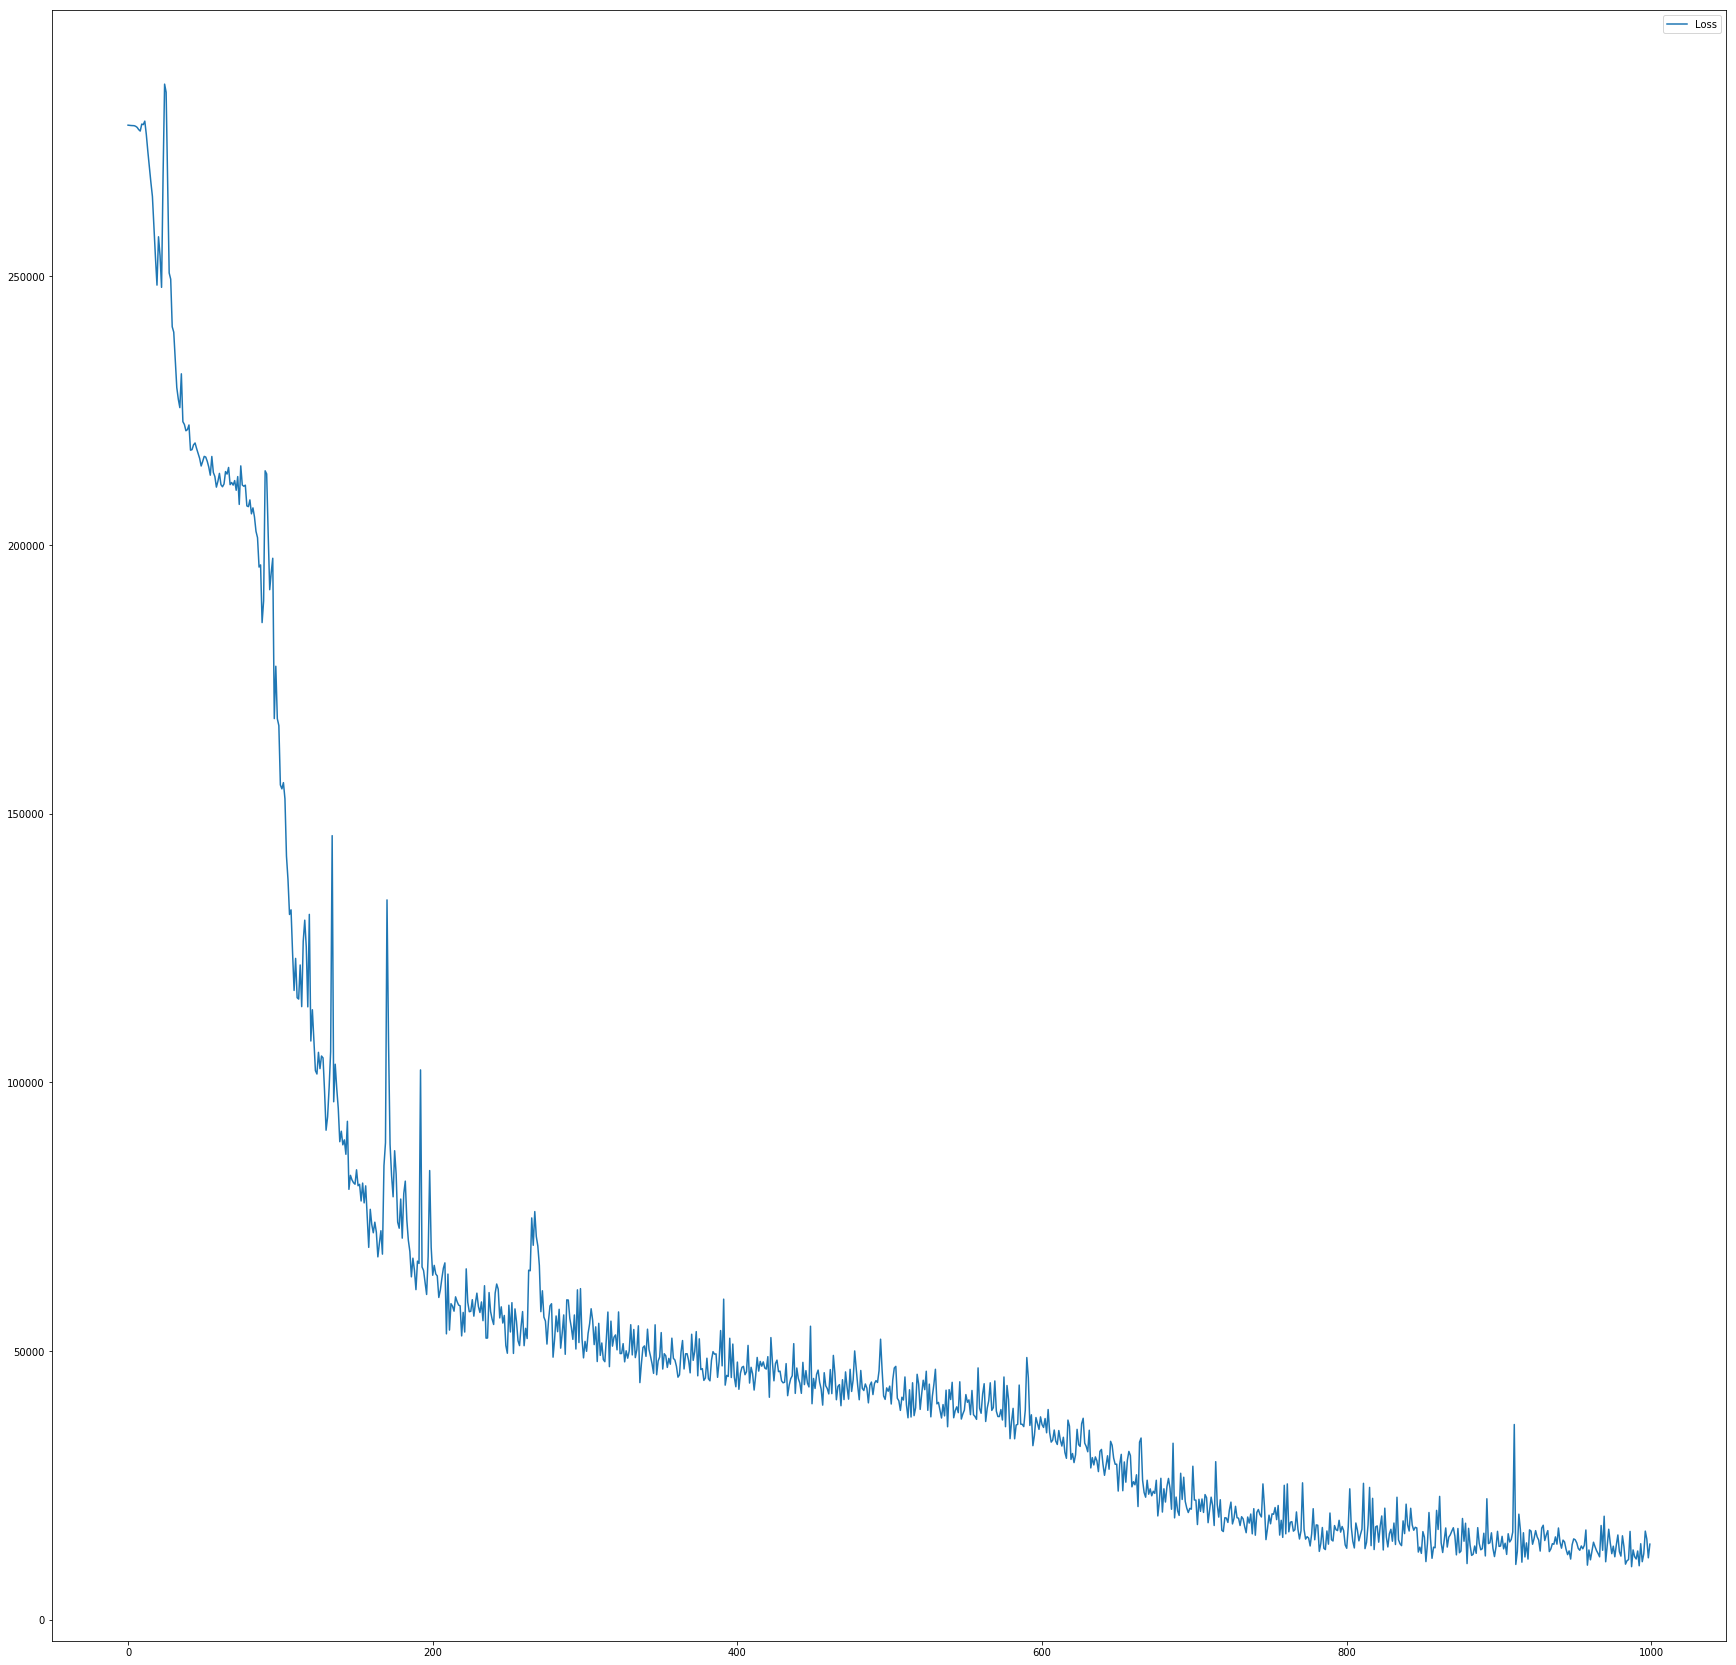

In [10]:
plt.figure(figsize=(30, 30))
plt.plot(btc_history.history["loss"])
#plt.plot(btc_history.history["val_loss"])
plt.legend(['Loss','Validation loss'])

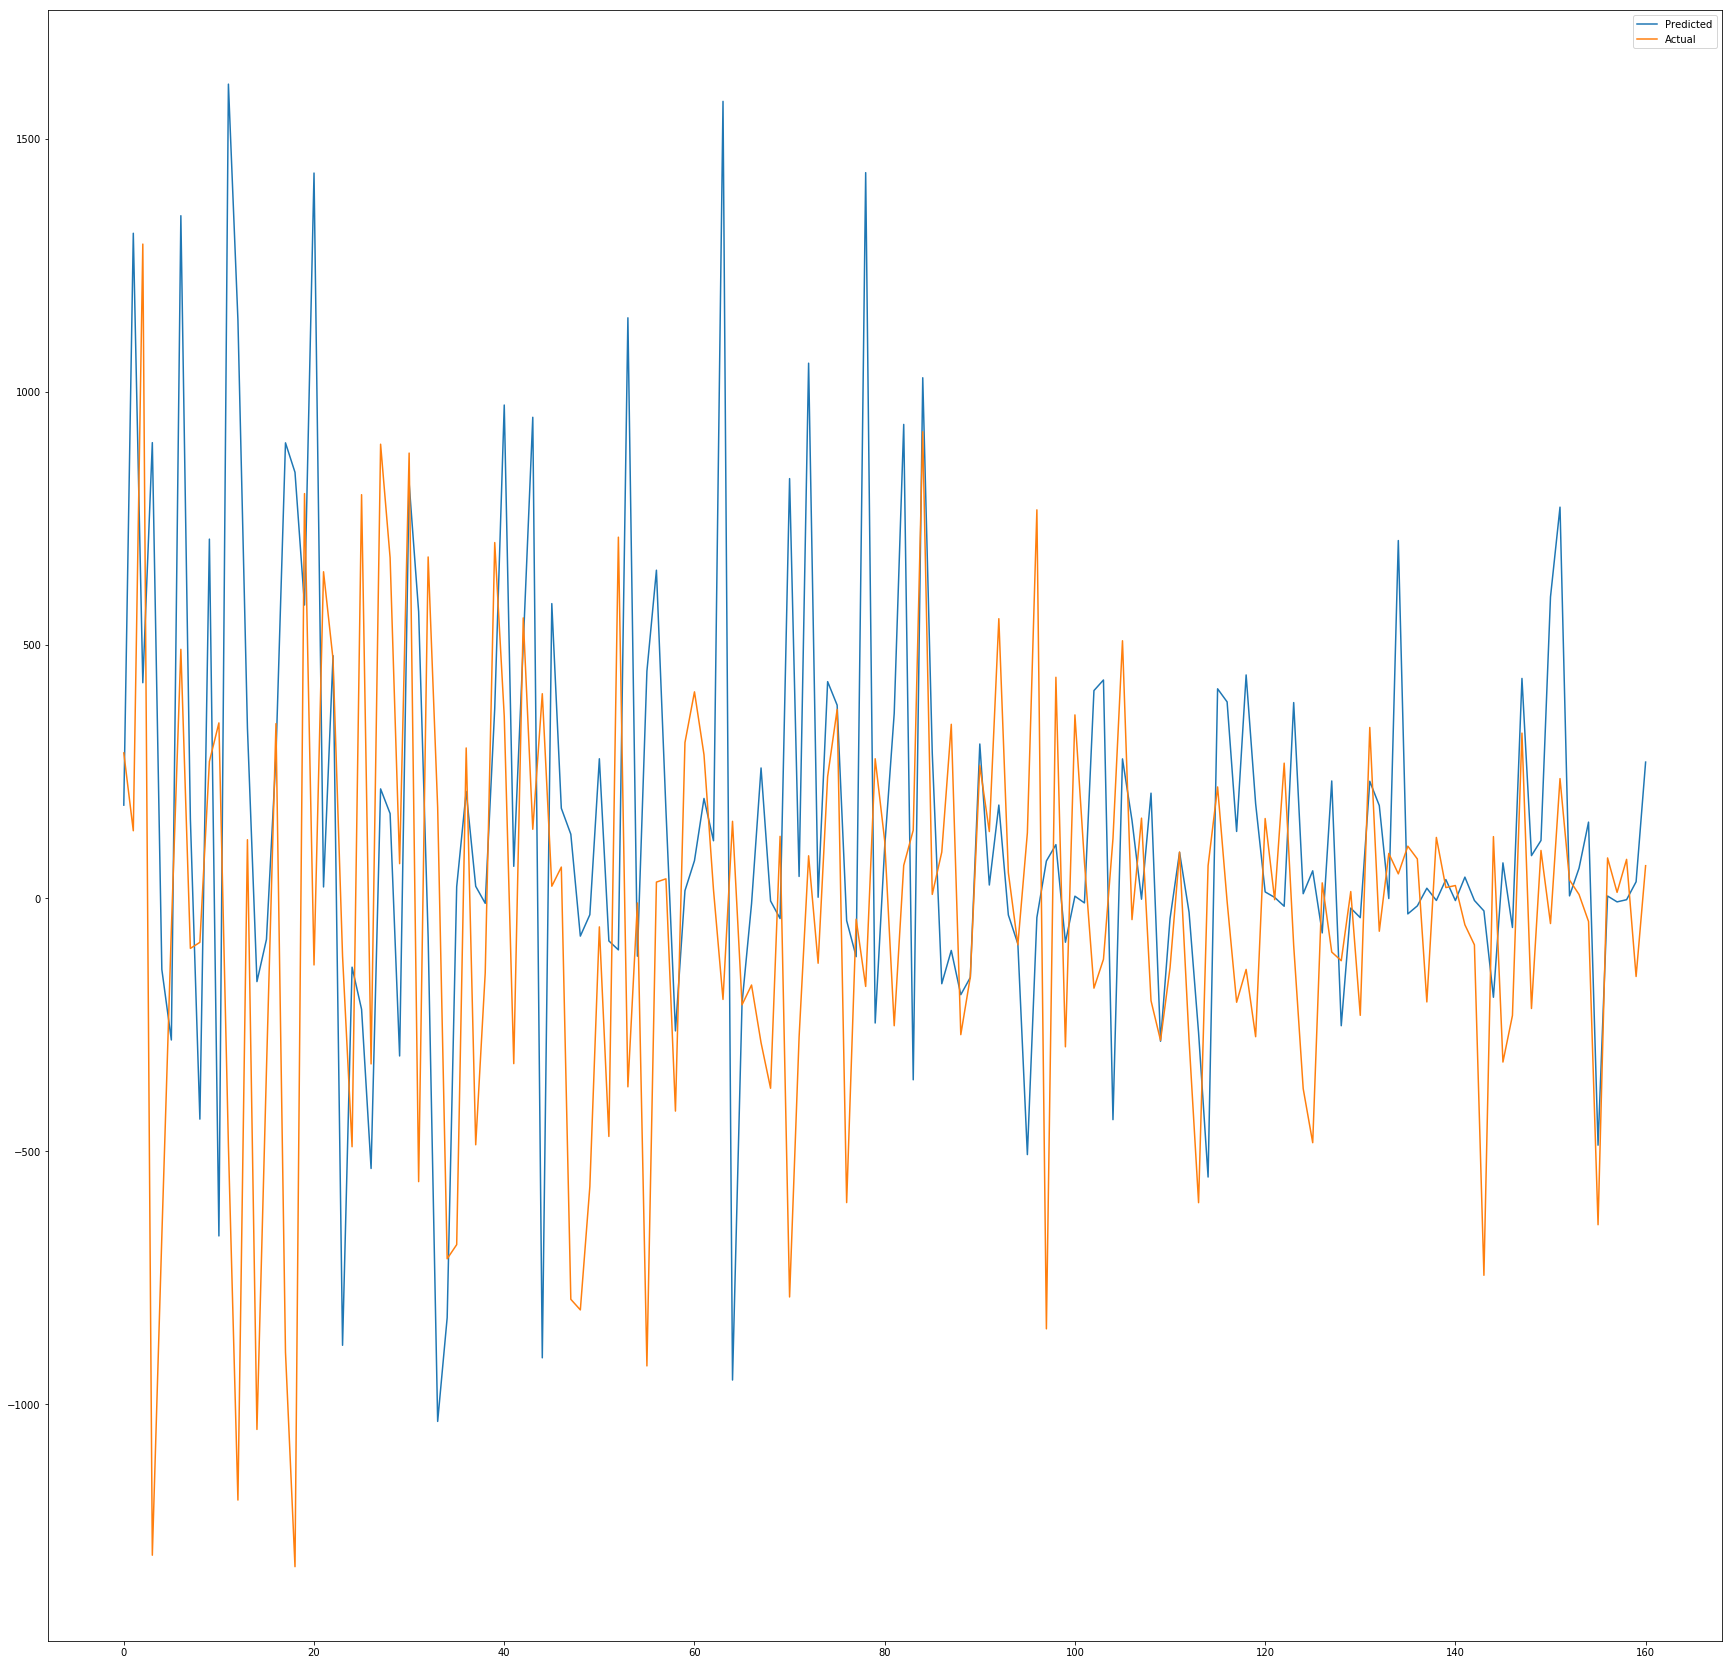

In [11]:
plt.figure(figsize=(30, 30))
plt.plot(btc_model.predict(X_test))
plt.plot(Y_test)
plt.legend(['Predicted','Actual'])

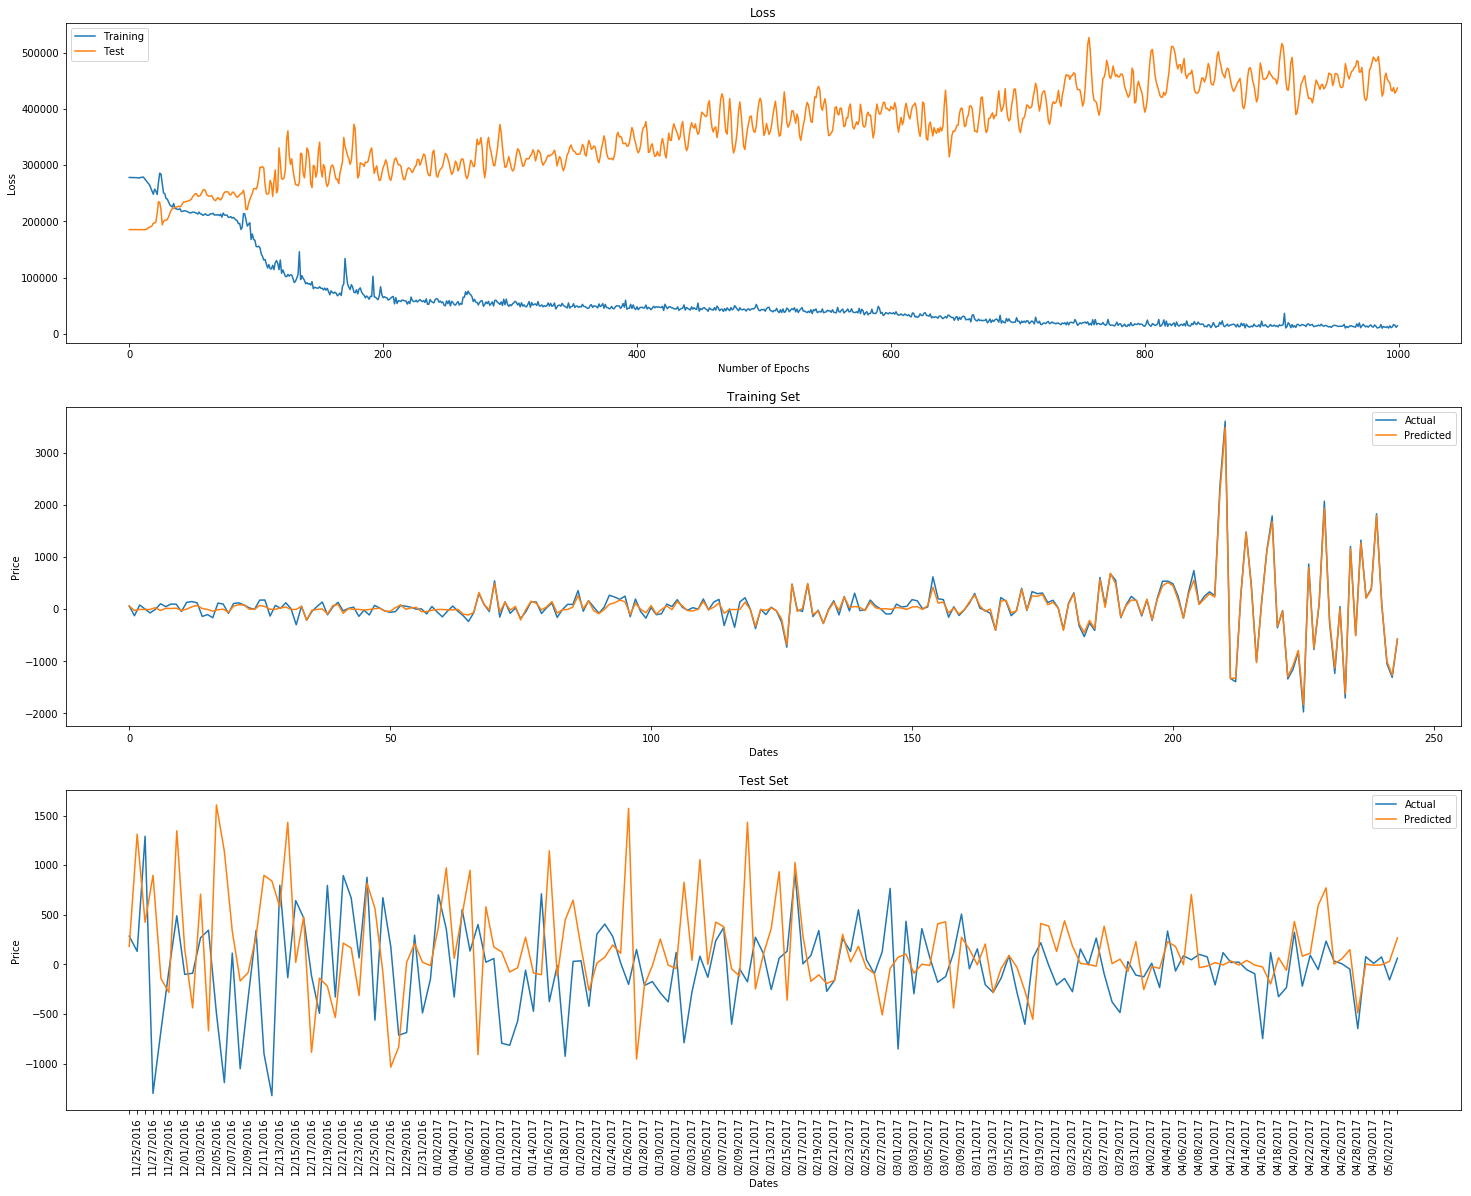

In [12]:
plot_results(btc_history, btc_model)